In [1]:
import torch
import numpy as np
import os
import sys

from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
pwd = '/home/lijiahao/workbench/sc-maskgit'
os.chdir(pwd)
sys.path.append(pwd)

In [2]:
def npy_to_loader(data_path, cond_path, batch_size):
    data = np.load(data_path, allow_pickle=True)
    cond = np.load(cond_path, allow_pickle=True)
    dataset = TensorDataset(
        torch.from_numpy(data.astype(int)),
        torch.from_numpy(cond.astype(int)).unsqueeze(1),
    )
    dataloader = DataLoader(
        dataset=dataset, shuffle=True, batch_size=batch_size, num_workers=4
    )
    return dataloader

### model

In [3]:
import torch
from muse_maskgit_pytorch import VQGanVAE, MaskGit, MaskGitTransformer

/mnt/sdc/lijiahao/miniconda3/envs/muse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transformer = MaskGitTransformer(
    num_tokens=51,  # must be same as codebook size above
    seq_len=1200,  # must be equivalent to fmap_size ** 2 in vae
    dim=512,  # model dimension
    depth=3,  # depth
    dim_head=64,  # attention head dimension
    heads=8,  # attention heads,
    ff_mult=4,  # feedforward expansion factor
    t5_name="t5-small",  # name of your T5, 如果没有 text 可以不用
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [5]:
base_maskgit = MaskGit(
    vae=None,  # vqgan vae
    transformer=transformer,  # transformer
    image_size=256,  # image size, 如果不做图像超分可以不用
    cond_drop_prob=0.25,  # conditional dropout, for classifier free guidance
).cuda()

In [6]:
batch_size = 64
loader = npy_to_loader(
    "./data/data_bins.npy", "./data/condition.npy", batch_size
)

In [7]:
max_step = 1000
lr = 1e-4
optimizer = torch.optim.Adam(base_maskgit.parameters(), lr=lr, weight_decay=0.045)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_step)
tq = tqdm(enumerate(loader), total=max_step)
for step, (images, texts) in tq:
    images = images.cuda()
    texts = texts.cuda()
    loss = base_maskgit(images, texts=texts)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    tq.set_description(f"loss: {loss.item():.3f}")
    if step >= max_step:
        break

loss: 0.756:  19%|█▉        | 188/1000 [02:41<11:39,  1.16it/s]


In [8]:
torch.save(base_maskgit.state_dict(), "maskgit.pt")

In [7]:
base_maskgit.load_state_dict(torch.load("maskgit.pt"))

/tmp/ipykernel_1499574/3753358151.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_maskgit.load_state_dict(torch.load("maskgit.pt"))


<All keys matched successfully>

In [8]:
cond = next(iter(loader))[1].cuda()

In [44]:
cond_idx = 0
manual_cond = torch.ones_like(cond) * cond_idx

In [45]:
pred_ids = base_maskgit.generate(manual_cond, seq_len=1200)

100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


In [46]:
import scanpy as sc

In [47]:
gen_data = sc.AnnData(
    pred_ids.cpu().numpy(), obs={"cell_type": cond.cpu().squeeze().numpy()}
)

In [48]:
gen_data.obs['cell_type'] = str(cond_idx) + '_gen'

In [49]:
input_ids = np.load("./data/data_bins.npy", allow_pickle=True)
input_cond = np.load("./data/condition.npy", allow_pickle=True)
input_data = sc.AnnData(input_ids, obs={"cell_type": input_cond})

In [50]:
m = sc.concat([input_data, gen_data])
m.obs['cell_type'] = m.obs['cell_type'].astype('category')

/mnt/sdc/lijiahao/miniconda3/envs/muse/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
input_data.obs['cell_type']

0        2
1        2
2        1
3        1
4        3
        ..
11985    1
11986    3
11987    7
11988    0
11989    1
Name: cell_type, Length: 11990, dtype: int8

In [52]:
input_data.obs['cell_type'].astype('category')

0        2
1        2
2        1
3        1
4        3
        ..
11985    1
11986    3
11987    7
11988    0
11989    1
Name: cell_type, Length: 11990, dtype: category
Categories (9, int8): [0, 1, 2, 3, ..., 5, 6, 7, 8]

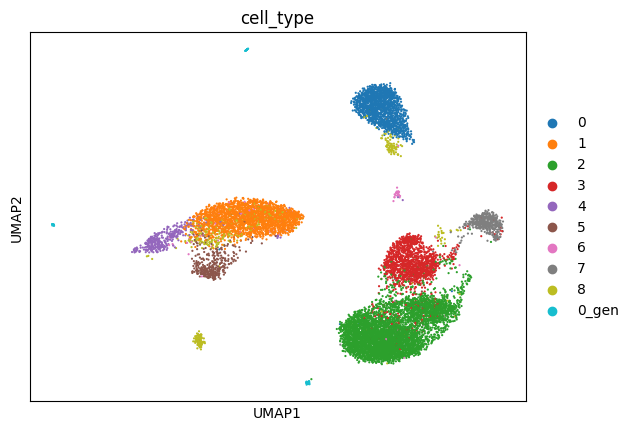

In [53]:
sc.pp.pca(m)
sc.pp.neighbors(m)
sc.tl.umap(m)
sc.pl.umap(m, color='cell_type')

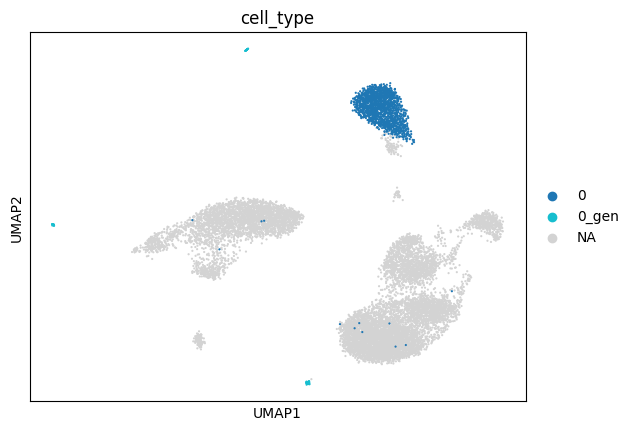

In [55]:
sc.pl.umap(m, color='cell_type', groups=[cond_idx, str(cond_idx) + '_gen'])

In [56]:
a  = list(range(100))

In [ ]:
x = [ i for i in range(100) if len([for j in range(2, i) if i % j == 0]) == 0]